In [176]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
import time
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

np.random.seed(42)
tf.random.set_seed(42)

In [177]:
# Load the dataset
dataset = pd.read_csv('emotion_review_classification.csv')

# Display the first few rows of the dataset
dataset

,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy
...,...,...,...,...,...,...,...,...,...,...,...
5395,Household,PCK-01 Penjepit Barang / Pickup Tool Ver.1 Ala...,Jakarta Pusat,35000,4.9,1431,562,5,"Harga bersaing, barang sesuai pesanan. Saya na...",Positive,Love
5396,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,Beli ini krn Anak & Istri mau liburan di Jakar...,Positive,Love
5397,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,"pengemasan barang baik, kondisi barang jg utuh...",Positive,Happy
5398,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,Mungil tapi bekerja dng baik. Dan murahh terja...,Positive,Happy


In [178]:
dataset['Emotion'].unique()

array(['Happy', 'Sadness', 'Anger', 'Love', 'Fear'], dtype=object)

In [179]:
# First, group the data by the 'Emotion' label and sample 100 from each group
test_data = dataset.groupby('Emotion').apply(lambda x: x.sample(n=100, random_state=42)).reset_index(drop=True)

# Now, create a dataset excluding the test data
dataset = dataset.drop(test_data.index)

In [180]:
test_data.head()

,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
0,Office & Stationery,Pengikat Kabel / Penggulung Cable / Binder Kli...,Jakarta Utara,900,4.9,20700,3246,1,"pihak toko tidak jelas, di minta barang a yg d...",Negative,Anger
1,Beauty,Madame Gie Silhouette Eyeliner Small (48 Jam) ...,Jakarta Barat,15000,4.8,5289,3346,1,"kalo mau kirim baca note nya dong,...masa tiga...",Negative,Anger
2,Other Products,BUBLE EXTRA,Jakarta Barat,2040,4.7,47600,5584,1,Mana gak ada bubble wrapnya,Negative,Anger
3,Office & Stationery,Document Bag Tas Dokumen Joyko DCB-49 - Bill,Jakarta Utara,18200,4.9,1555,504,1,"barang tidak sampai,kembalikan uang saya..!!!",Negative,Anger
4,Carpentry,Kepala Portable Gas Torch Flame Gun Las Blow T...,Jakarta Utara,21123,4.9,7634,1361,1,Barangnya gk berfungsi semestinya,Negative,Anger


In [181]:
indexes = [41, 99, 146, 177, 280, 283, 364, 339, 441, 450]

selected_data = test_data[['Customer Review', 'Emotion']].iloc[indexes]
selected_data

,Customer Review,Emotion
41,"kartunya kw semua,katanya ori gimana sih",Anger
99,Baru pake sekali per nya lepas2 terus ampas,Anger
146,Barang tidak sesuai pesanan ... Mohon pendataa...,Fear
177,lamaaa bangettt respons nya,Fear
280,Sesuai deskripsi� seller gercep & interaktif� ...,Happy
283,Mantap ori,Happy
364,"Nyaman dipakai, kemasan bagus, pengiriman super !",Love
339,sudah diterima dengan baik mantafffffffffffff,Love
441,bahannya jelek kualitasnya sangat jelek baru b...,Sadness
450,"barang jelek, belom d pake udah pada patah",Sadness


In [182]:
dataset

,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
500,Food and Drink,Artisan Bagel 4pcs - Mix of 4,Jakarta Barat,41000,4.8,2523,1134,1,Roti keras gak enak,Negative,Anger
501,Food and Drink,Keripik Pisang Coklat Aneka Yen-Yen Lampung Ke...,Kota Bandar Lampung,18000,4.9,33200,3233,1,hancur patah patah semua,Negative,Anger
502,Food and Drink,ARUTALA Kopi Vietnam Central Highland Robusta ...,Kota Tangerang,40000,4.9,4460,1994,1,busyeettt..lamaaa amit nyampe brgnya.pdhl udh ...,Negative,Anger
503,Food and Drink,Kopi Arabika GAYO WINE | biji Kopi Aceh single...,Jakarta Utara,109000,4.9,9056,3683,1,Minta halus dikirim kasar....laen ngopi duli b...,Negative,Anger
504,Food and Drink,Granola Chocolate Vanilla 400g - Granola Cokel...,Jakarta Timur,69900,5.0,3919,1363,1,Parah respon nya Butuh 4 hr sejak order baru d...,Negative,Anger
...,...,...,...,...,...,...,...,...,...,...,...
5395,Household,PCK-01 Penjepit Barang / Pickup Tool Ver.1 Ala...,Jakarta Pusat,35000,4.9,1431,562,5,"Harga bersaing, barang sesuai pesanan. Saya na...",Positive,Love
5396,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,Beli ini krn Anak & Istri mau liburan di Jakar...,Positive,Love
5397,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,"pengemasan barang baik, kondisi barang jg utuh...",Positive,Happy
5398,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,Mungil tapi bekerja dng baik. Dan murahh terja...,Positive,Happy


In [183]:
dataset.sample(n=20, random_state=42)

,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
5157,Beauty,L'Oreal Paris Mascara Waterproof Lash Paradise...,Kota Tangerang Selatan,169000,4.9,10400,4125,4,Bulu mata jadi lentik. Packaging rapi. Packagi...,Positive,Happy
4039,Kitchen,ecentio Kotak Makan Siang Desain Tingkat 800/1...,Kab. Bekasi,200000,4.9,3441,1837,2,Material Produk Bagus. Ukuran Produk Sesuai. W...,Negative,Sadness
1407,Party Supplies and Craft,box clover segi 4 / kotak kado hadiah gift mak...,Kota Tangerang,12900,4.7,3930,395,5,Barang yg di pesan sesuai dan packing rapi,Positive,Happy
4853,Phones and Tablets,"TRIPOD 2,1 METER Stand Kamera HP Selfie Make U...",Kab. Tangerang,110000,4.7,8821,2533,5,Berfungsi dengan baik. Kualitas sesuai harga. ...,Positive,Happy
4245,Kids and Baby Fashion,Tas Sekolah Anak SD Cewek/Cewe/Perempuan 2 in ...,Kab. Bandung,55000,4.8,1713,818,5,"Alhamdulillah terimkasih seller, Tas nya bagus...",Positive,Love
5133,Beauty,2IN1 KUTEK HALAL KUTEK 2 TONE KUTEK KOREA - B26,Kota Tangerang,20000,4.9,6013,1998,4,"barang dateng tidak sesuai dengan pesanan, bed...",Negative,Sadness
2744,Kids and Baby Fashion,immo z7 jam tangan anak anti air,Jakarta Pusat,199000,4.7,1285,433,3,Ternyata tidak sesuai. Tidak dpat dipakai,Negative,Fear
2424,Books,Midnight Library /UK,Jakarta Timur,198000,5.0,271,159,5,"cepet banget pengirimannya, pengemasannya pun ...",Positive,Happy
4302,Muslim Fashion,Konektor Masker Hijab Kristal Premium Hijaberl...,Kota Depok,21900,4.9,804,207,5,barangnya bagus,Positive,Happy
3134,Movies and Music,pad drum 10 inchi murah,Jakarta Pusat,59500,4.7,1275,550,4,"barang sesuai keinginan, thx toko pedia.",Positive,Happy


In [184]:
# 1. Pembersihan Data

# Select the necessary columns
data = dataset[['Customer Review', 'Emotion']]

# Drop rows with missing values
data = data.dropna()

# Remove duplicates
data = data.drop_duplicates()

# Basic cleaning: convert to lowercase and remove special characters

# 1. Mengubah ke huruf kecil
data['Customer Review'] = data['Customer Review'].str.lower()

# 2. Mengganti karakter yang bukan huruf dengan spasi
data['Customer Review'] = data['Customer Review'].str.replace(r'[^a-z\s]', ' ', regex=True)

# 3. Menghilangkan spasi berlebih
data['Customer Review'] = data['Customer Review'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

In [185]:
data.sample(10)

,Customer Review,Emotion
3758,dusnya robek dan terbuka kemasannyaa,Fear
2222,sudah diterima dengan baik terimakasih,Happy
1569,kapok saya beli kembang api di toko ini bilang...,Fear
4698,barang udah nyampe makasih broo,Happy
2071,kacamata sangat rentan dipakai sekali patah ka...,Sadness
1559,mantap jiwo thx gan product sudah saya terima ...,Love
2653,baru datang saya rakit coba naikan kulkas baru...,Sadness
4810,imei terdaftar di kemenperin barangnya origina...,Happy
4574,tidak sebagus di gambar kain tepi di neci aja ...,Sadness
4122,toko paling ga niat jualan beli tanggal baru d...,Sadness


In [186]:
data

,Customer Review,Emotion
500,roti keras gak enak,Anger
501,hancur patah patah semua,Anger
502,busyeettt lamaaa amit nyampe brgnya pdhl udh x...,Anger
503,minta halus dikirim kasar laen ngopi duli biar...,Anger
504,parah respon nya butuh hr sejak order baru dik...,Anger
...,...,...
5395,harga bersaing barang sesuai pesanan saya namb...,Love
5396,beli ini krn anak istri mau liburan di jakarta...,Love
5397,pengemasan barang baik kondisi barang jg utuh ...,Happy
5398,mungil tapi bekerja dng baik dan murahh terjan...,Happy


In [187]:
data.iloc[[4603, 3485, 3730, 2198, 3141]]

,Customer Review,Emotion
5157,bulu mata jadi lentik packaging rapi packaging...,Happy
4039,material produk bagus ukuran produk sesuai war...,Sadness
4284,suka banget sama strap maskernya lucu bagus ba...,Love
2744,ternyata tidak sesuai tidak dpat dipakai,Fear
3693,pengemasan lambat banget pengiriman lamaaaaaa,Anger


In [188]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 500 to 5399
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         4900 non-null   object 
 1   Product Name     4900 non-null   object 
 2   Location         4900 non-null   object 
 3   Price            4900 non-null   int64  
 4   Overall Rating   4900 non-null   float64
 5   Number Sold      4900 non-null   int64  
 6   Total Review     4900 non-null   int64  
 7   Customer Rating  4900 non-null   int64  
 8   Customer Review  4900 non-null   object 
 9   Sentiment        4900 non-null   object 
 10  Emotion          4900 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 421.2+ KB


In [189]:
dataset.head()

,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
500,Food and Drink,Artisan Bagel 4pcs - Mix of 4,Jakarta Barat,41000,4.8,2523,1134,1,Roti keras gak enak,Negative,Anger
501,Food and Drink,Keripik Pisang Coklat Aneka Yen-Yen Lampung Ke...,Kota Bandar Lampung,18000,4.9,33200,3233,1,hancur patah patah semua,Negative,Anger
502,Food and Drink,ARUTALA Kopi Vietnam Central Highland Robusta ...,Kota Tangerang,40000,4.9,4460,1994,1,busyeettt..lamaaa amit nyampe brgnya.pdhl udh ...,Negative,Anger
503,Food and Drink,Kopi Arabika GAYO WINE | biji Kopi Aceh single...,Jakarta Utara,109000,4.9,9056,3683,1,Minta halus dikirim kasar....laen ngopi duli b...,Negative,Anger
504,Food and Drink,Granola Chocolate Vanilla 400g - Granola Cokel...,Jakarta Timur,69900,5.0,3919,1363,1,Parah respon nya Butuh 4 hr sejak order baru d...,Negative,Anger


In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4845 entries, 500 to 5399
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Customer Review  4845 non-null   object
 1   Emotion          4845 non-null   object
dtypes: object(2)
memory usage: 113.6+ KB


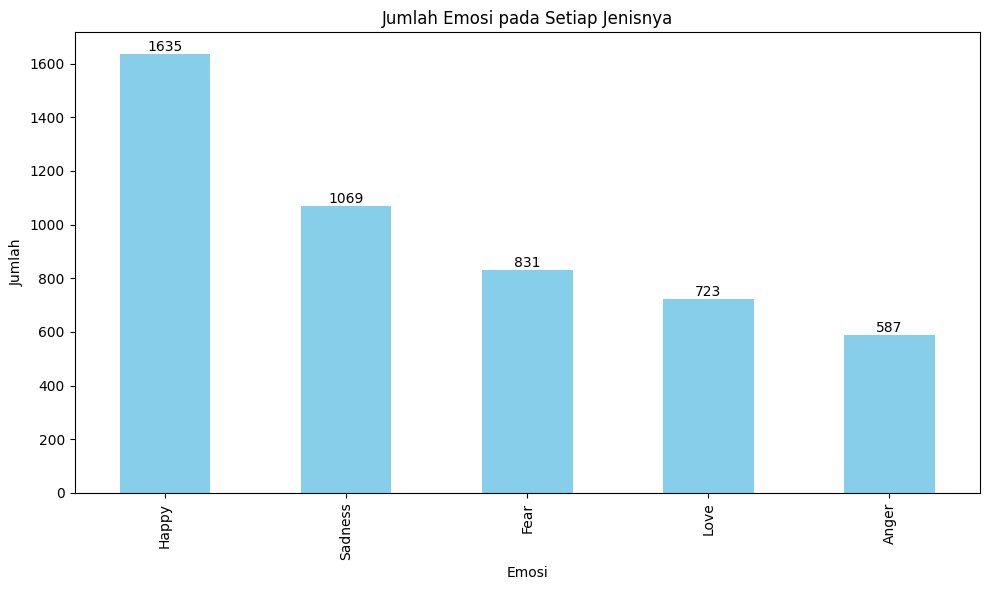

In [191]:
import pandas as pd
import matplotlib.pyplot as plt

# Menghitung jumlah masing-masing emosi
emotion_counts = data['Emotion'].value_counts()

# Membuat grafik bar
plt.figure(figsize=(10, 6))
emotion_plot = emotion_counts.plot(kind='bar', color='skyblue')

# Menampilkan angka untuk masing-masing bar
for index, value in enumerate(emotion_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Jumlah Emosi pada Setiap Jenisnya')
plt.xlabel('Emosi')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

In [192]:
texts = data['Customer Review'].astype(str).tolist()  # Convert reviews to list of strings
labels = data['Emotion'].tolist()  # Convert emotion labels to list

# Parameters
vocab_size = 7000  # Consider the top 10k words
maxlen = 40  # Maximum length of the sequences

# Tokenize the text
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad the sequences
x_data = pad_sequences(sequences, maxlen=maxlen, padding='post')

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [193]:
# Encode labels
labels = data['Emotion'].tolist()
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(labels)
y_data = y_data.reshape(-1, 1)  # Reshape for sparse_categorical_crossentropy

# Save the label encoder
with open('label_encoder.pickle', 'wb') as file:
    pickle.dump(label_encoder, file, protocol=pickle.HIGHEST_PROTOCOL)

In [194]:
x_data[1]

array([533, 200, 200, 104,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

In [195]:
# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [196]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((3876, 40), (3876, 1), (969, 40), (969, 1))

In [197]:
import tensorflow as tf
from tensorflow.keras import layers

@tf.keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate
        })
        return config

@tf.keras.utils.register_keras_serializable()
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super(TokenAndPositionEmbedding, self).get_config()
        config.update({
            'maxlen': self.maxlen,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim
        })
        return config


In [198]:
# Define the model parameters
embed_dim = 32 # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

regularizer = keras.regularizers.l2(0.001)

# Build the model
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train.flatten()
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

In [199]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

In [200]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
# Compile the model
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Catat waktu mulai
start_time = time.time()

# Train the model with class weights
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=200,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    class_weight=class_weight_dict  # Add class weights here
)

# Catat waktu berakhir
end_time = time.time()

# Hitung waktu yang diperlukan untuk mengeksekusi seluruh kode
runtime = end_time - start_time

print(f"Waktu runtime: {runtime} detik")

# Save the model
model.save('transformer_emotion.keras', save_format='tf')

Epoch 1/200
122/122 [==============================] - 5s 22ms/step - loss: 1.6033 - accuracy: 0.2466 - val_loss: 1.5569 - val_accuracy: 0.3478
Epoch 2/200
122/122 [==============================] - 3s 27ms/step - loss: 1.5835 - accuracy: 0.2588 - val_loss: 1.5462 - val_accuracy: 0.3591
Epoch 3/200
122/122 [==============================] - 3s 23ms/step - loss: 1.5513 - accuracy: 0.3230 - val_loss: 1.5169 - val_accuracy: 0.3653
Epoch 4/200
122/122 [==============================] - 3s 21ms/step - loss: 1.5026 - accuracy: 0.3437 - val_loss: 1.4407 - val_accuracy: 0.4293
Epoch 5/200
122/122 [==============================] - 2s 20ms/step - loss: 1.3922 - accuracy: 0.4033 - val_loss: 1.2803 - val_accuracy: 0.4510
Epoch 6/200
122/122 [==============================] - 3s 21ms/step - loss: 1.2293 - accuracy: 0.4492 - val_loss: 1.1674 - val_accuracy: 0.4324
Epoch 7/200
122/122 [==============================] - 4s 30ms/step - loss: 1.1001 - accuracy: 0.4732 - val_loss: 1.0942 - val_accuracy:

# Hasil

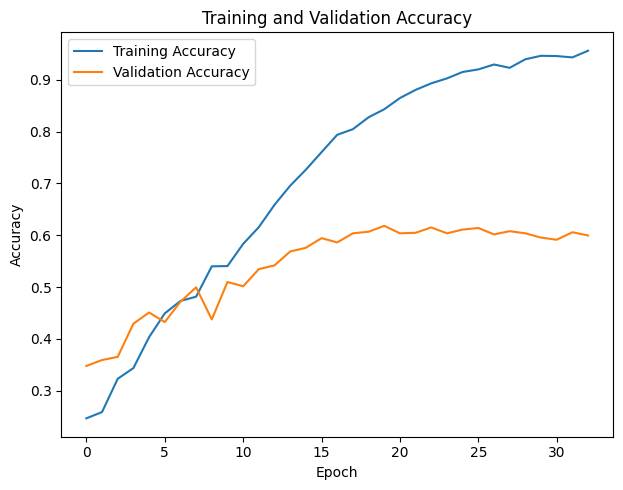

In [201]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

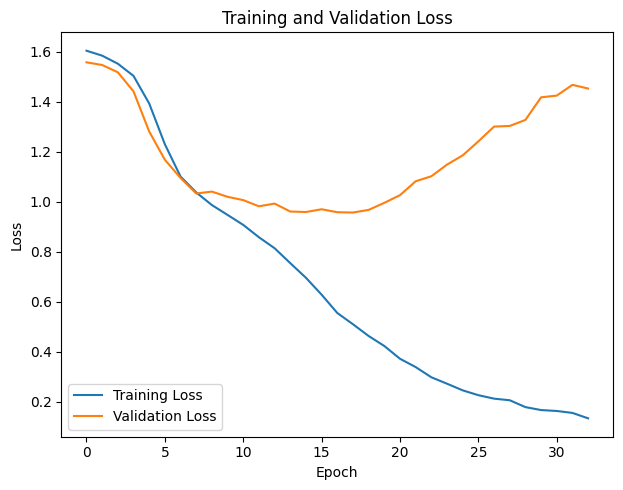

In [202]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [203]:
from sklearn.metrics import confusion_matrix, accuracy_score

def predict_emotion(data, tokenizer, model, label_encoder, maxlen):
    # Basic cleaning: convert to lowercase and remove special characters

    # 1. Mengubah ke huruf kecil
    data['Customer Review'] = data['Customer Review'].str.lower()

    # 2. Mengganti karakter yang bukan huruf dengan spasi
    data['Customer Review'] = data['Customer Review'].str.replace(r'[^a-z\s]', ' ', regex=True)

    # 3. Menghilangkan spasi berlebih
    data['Customer Review'] = data['Customer Review'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

    # Initialize an empty list to store the predictions
    predictions = []

    # Iterate through each row in the dataframe
    for text in data['Customer Review']:
        # Tokenize the input text
        sequence = tokenizer.texts_to_sequences([text])

        # Pad the sequence
        padded_sequence = pad_sequences(sequence, maxlen=maxlen)

        # Make a prediction
        prediction = model.predict(padded_sequence)

        # Get the class index with the highest probability
        class_index = np.argmax(prediction, axis=1)

        # Decode the predicted class index back to the class label
        class_label = label_encoder.inverse_transform(class_index)

        # Append the predicted label to the list
        predictions.append(class_label[0])

    # Create a new DataFrame with the original reviews, true labels, and predicted labels
    result_df = pd.DataFrame({
        'Customer Review': data['Customer Review'],
        'Emotion': data['Emotion'],
        'Predicted Emotion': predictions
    })

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(result_df['Emotion'], result_df['Predicted Emotion'], labels=label_encoder.classes_)

    # Calculate accuracy
    accuracy = accuracy_score(result_df['Emotion'], result_df['Predicted Emotion'])

    return result_df, conf_matrix, accuracy

# Usage
predicted_df, conf_matrix, accuracy = predict_emotion(test_data, tokenizer, model, label_encoder, maxlen)

1/1 [==============================] - 0s 23ms/step


In [204]:
accuracy

0.754

In [205]:
conf_matrix

array([[76, 12,  1,  0, 11],
       [ 9, 74,  3,  1, 13],
       [ 0,  1, 90,  8,  1],
       [ 0,  0, 40, 60,  0],
       [14,  7,  2,  0, 77]])